In [126]:
import cv2
import pandas as pd
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

In [127]:
def get_video_frame(video_path, frame_number):
    """
    Extract a specific frame from a video file.

    Parameters:
    -----------
    video_path : str
        Path to the video file
    frame_number : int
        Frame number to extract (0-based indexing)

    Returns:
    --------
    numpy.ndarray
        The requested frame as a numpy array (BGR format)
        Returns None if frame cannot be retrieved

    Raises:
    -------
    ValueError
        If frame_number is negative
    FileNotFoundError
        If video file doesn't exist
    """

    if frame_number < 0:
        raise ValueError("Frame number must be non-negative")

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video file: {video_path}")

    try:
        # Get total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Check if frame number is within valid range
        if frame_number >= total_frames:
            print(f"Warning: Frame {frame_number} exceeds total frames ({total_frames}). Returning None.")
            return None

        # Set the video position to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read the frame
        ret, frame = cap.read()

        if ret:
            return frame
        else:
            print(f"Failed to read frame {frame_number}")
            return None

    finally:
        # Always release the video capture object
        cap.release()

def adjust_image(image, brightness=0, contrast=1.0, saturation=1.0, gamma=1.0,
                 hue=0, exposure=0, temperature=0, highlights=0, shadows=0):
    """
    Adjust visual parameters of an image.

    Parameters:
    -----------
    image : numpy.ndarray
        Input image in BGR format
    brightness : int, optional
        Brightness adjustment (-100 to 100), default=0
    contrast : float, optional
        Contrast multiplier (0.5 = half, 2.0 = double), default=1.0
    saturation : float, optional
        Saturation multiplier (0 = grayscale, >1 = more saturated), default=1.0
    gamma : float, optional
        Gamma correction (<1 = brighter, >1 = darker), default=1.0
    hue : int, optional
        Hue shift in degrees (-180 to 180), default=0
    exposure : float, optional
        Exposure adjustment in stops (-2.0 to 2.0), default=0
    temperature : float, optional
        Color temperature (-100 = cool, 100 = warm), default=0
    highlights : float, optional
        Highlights adjustment (-100 to 100), default=0
    shadows : float, optional
        Shadows adjustment (-100 to 100), default=0

    Returns:
    --------
    numpy.ndarray
        Adjusted image
    """
    # Work on a copy to avoid modifying the original
    result = image.copy()

    # Brightness adjustment
    if brightness != 0:
        result = cv2.convertScaleAbs(result, alpha=1, beta=brightness)

    # Contrast adjustment
    if contrast != 1.0:
        mean = np.mean(result)
        result = cv2.convertScaleAbs(result, alpha=contrast, beta=(1 - contrast) * mean)

    # Gamma correction
    if gamma != 1.0:
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255
                         for i in np.arange(0, 256)]).astype("uint8")
        result = cv2.LUT(result, table)

    # Saturation adjustment
    if saturation != 1.0:
        hsv = cv2.cvtColor(result, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 1] = hsv[:, :, 1] * saturation
        hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
        result = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Hue adjustment
    if hue != 0:
        hsv = cv2.cvtColor(result, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 0] = (hsv[:, :, 0] + hue/2) % 180
        result = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Exposure adjustment
    if exposure != 0:
        multiplier = 2.0 ** exposure
        result = cv2.convertScaleAbs(result, alpha=multiplier, beta=0)

    # Temperature adjustment
    if temperature != 0:
        temp_result = result.astype(np.float32)
        if temperature > 0:  # Warm
            temp_result[:, :, 2] *= 1 + (temperature / 200)  # Increase red
            temp_result[:, :, 0] *= 1 - (temperature / 200)  # Decrease blue
        else:  # Cool
            temp_result[:, :, 0] *= 1 + (abs(temperature) / 200)  # Increase blue
            temp_result[:, :, 2] *= 1 - (abs(temperature) / 200)  # Decrease red
        result = np.clip(temp_result, 0, 255).astype(np.uint8)

    # Highlights and shadows adjustment
    if highlights != 0 or shadows != 0:
        lab = cv2.cvtColor(result, cv2.COLOR_BGR2LAB).astype(np.float32)
        l_channel = lab[:, :, 0]

        highlight_mask = l_channel / 255.0
        shadow_mask = 1.0 - highlight_mask

        l_channel += highlights * highlight_mask * (255 - l_channel) / 100
        l_channel += shadows * shadow_mask * l_channel / 100

        lab[:, :, 0] = np.clip(l_channel, 0, 255)
        result = cv2.cvtColor(lab.astype(np.uint8), cv2.COLOR_LAB2BGR)

    return result



In [128]:
plot_dir = '../../PLOTS/response_to_reviewers'
if os.path.exists(plot_dir) != True:
    os.makedirs(plot_dir)

In [129]:
example_3t_video = r'D:\Octopus_OdorTracking\DATA\3T\3t\khorne_9_20_001_eat_11\khorne_9_20_001_eat_11_f7_t882.mp4'
frame3t = get_video_frame( example_3t_video , 20)
path_img = os.path.join(plot_dir, 'example_3t.png')
cv2.imwrite(path_img, frame3t)

True

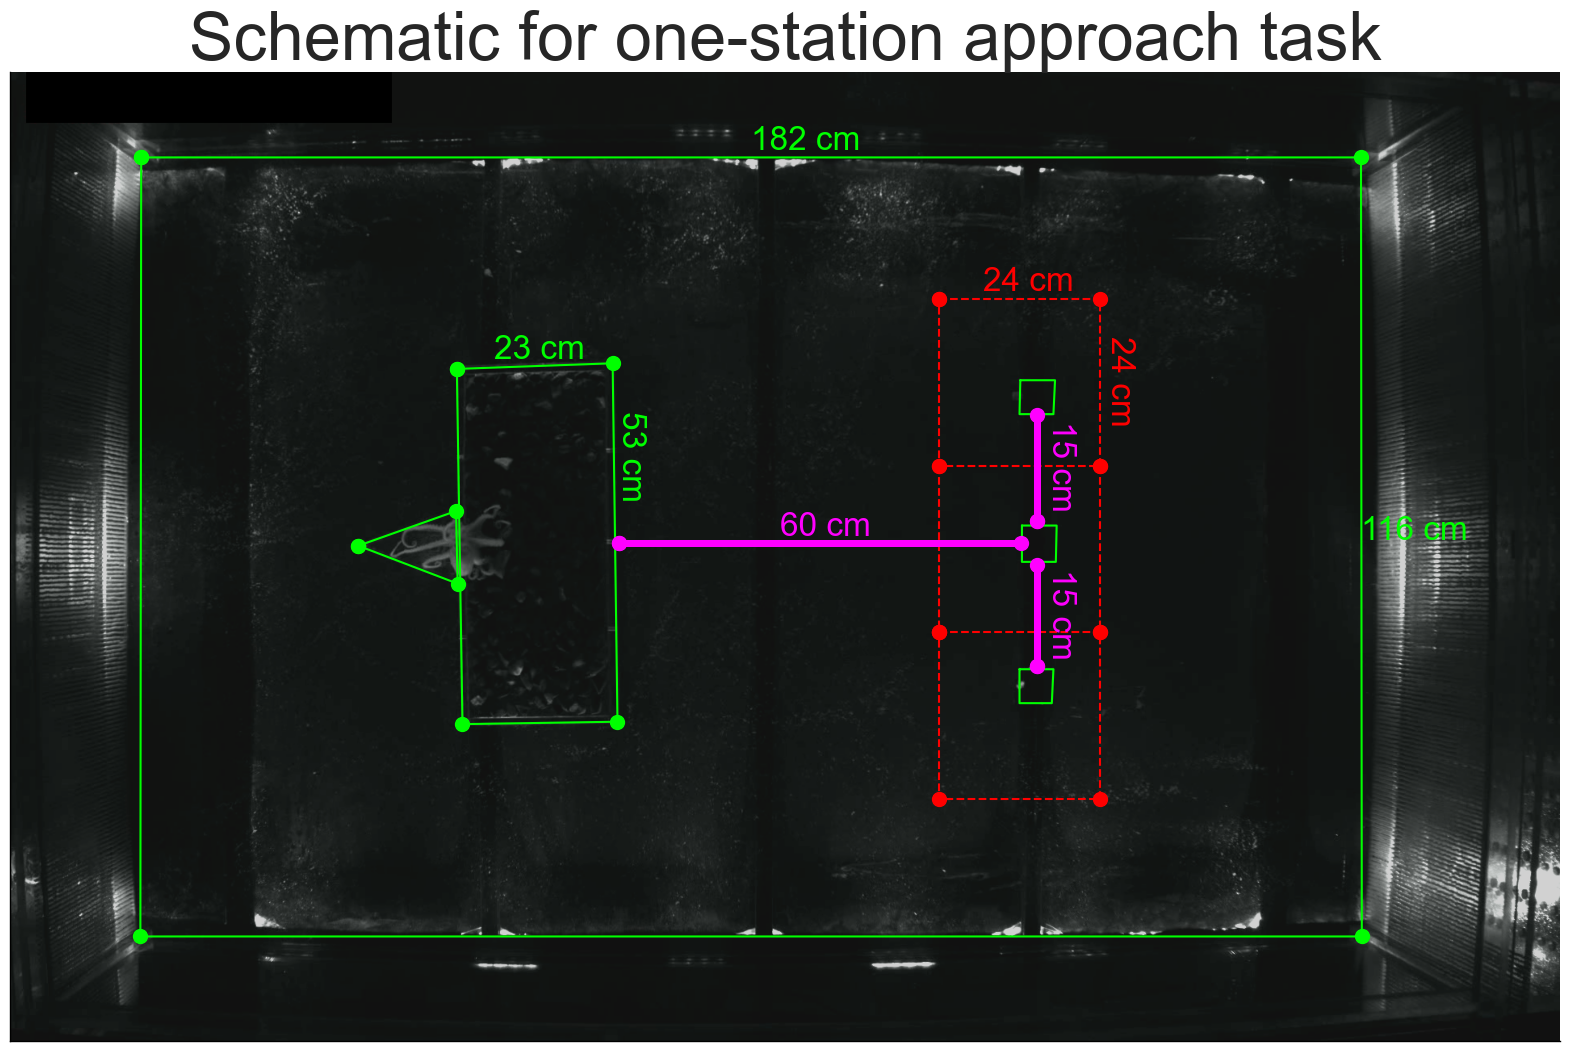

In [189]:
def get_polygon_coords (coord_tuples):
    x_coords = [r[0] for r in coord_tuples]
    x_coords.append(coord_tuples[0][0])
    y_coords = [r[1] for r in coord_tuples]
    y_coords.append(coord_tuples[0][1])

    return x_coords, y_coords

def get_draw_distance_info (coord_pair):
    x0, y0 = coord_pair[0][0], coord_pair[0][1]
    x1, y1 = coord_pair[1][0], coord_pair[1][1]

    xd = (x0+x1)/2
    yd = (y0+y1)/2

    D = np.sqrt((x0-x1)**2 + (y0-y1)**2)

    return (xd, yd), D

inches_per_pixel = 1/21
cm_per_pixel = inches_per_pixel * 2.54

fig, ax = plt.subplots(1,1,figsize=(20,20))

rock_tray = [(553, 367), (746, 360), (752, 804), (560, 807)]
rock_tray_x, rock_tray_y = get_polygon_coords (rock_tray)
for i in range(len(rock_tray)-2):
    (xd, yd), D = get_draw_distance_info((rock_tray[i], rock_tray[i+1]))
    D = int(D*cm_per_pixel)
    if i == 0:
        ax.text(xd-50, yd-10, str(D) + ' cm', color='lime', fontsize=24)
    else:
        ax.text(xd, yd-60, str(D) + ' cm', color='lime', fontsize=24, rotation=-90)
den = [(431, 586), (552, 543), (554, 633)]
den_x, den_y = get_polygon_coords(den)


station_0 = [(1251, 381), (1294, 381), (1292, 423), (1250, 423)]
st_0x, st_0y = get_polygon_coords(station_0)

station_1 = [(1253, 561), (1296,561), (1295, 606), (1253, 606)]
st_1x, st_1y = get_polygon_coords(station_1)

station_0_1 = [(1272, 555), (1272, 424)]
walking_x, walking_y = get_polygon_coords(station_0_1 )
(xd, yd), D = get_draw_distance_info((station_0_1 [0], station_0_1 [1]))
D = int(D*cm_per_pixel)
ax.text(xd+10, yd+45, str(D) + ' cm', color='magenta', fontsize=24, rotation=-90)
ax.plot(walking_x, walking_y, color='magenta', linewidth=5, marker='.', markersize=20, zorder=4)

station_2 = [(1250, 739), (1292, 739), (1290, 781), (1250, 781)]
st_2x, st_2y = get_polygon_coords(station_2)

station_1_2 = [(1272, 735), (1272, 610)]
walking_x, walking_y = get_polygon_coords(station_1_2 )
(xd, yd), D = get_draw_distance_info((station_1_2 [0], station_1_2 [1]))
D = int(D*cm_per_pixel)
ax.text(xd+10, yd+45, str(D) + ' cm', color='magenta', fontsize=24, rotation=-90)
ax.plot(walking_x, walking_y, color='magenta', linewidth=5, marker='.', markersize=20, zorder=4)

space_edges = [(162, 105), (1673, 105), (1674, 1070), (161, 1070)]
space_edges_x, space_edges_y = get_polygon_coords(space_edges)
for i in range(len(space_edges)-2):
    (xd, yd), D = get_draw_distance_info((space_edges[i], space_edges[i+1]))
    D = int(D*cm_per_pixel)
    ax.text(xd, yd-10, str(D) + ' cm', color='lime', fontsize=24)

walking_distance = [(754, 583), (1252, 583)]
walking_x, walking_y = get_polygon_coords(walking_distance)
(xd, yd), D = get_draw_distance_info((walking_distance[0], walking_distance[1]))
D = int(D*cm_per_pixel)
ax.text(xd-50, yd-10, str(D) + ' cm', color='magenta', fontsize=24)
ax.plot(walking_x, walking_y, color='magenta', linewidth=5, marker='.', markersize=20, zorder=4)

ax.imshow(adjust_image(frame3t, brightness=15 ,contrast=.8))

ax.plot(rock_tray_x, rock_tray_y, color='lime', marker='.', markersize=20)
ax.plot(den_x, den_y, color='lime', marker='.', markersize=20)
ax.plot(st_0x,st_0y, color='lime')
ax.plot(st_1x,st_1y, color='lime')
ax.plot(st_2x,st_2y, color='lime')
ax.plot(space_edges_x, space_edges_y, color='lime', marker='.', markersize=20)


Dx, Ux = 1150, 1350
y0, y3 = 280, 900
y1 = y0 + (1/3)*(y3-y0)
y2 = y0 + (2/3)*(y3-y0)

station_0_b = [(Dx, y0), (Ux, y0), (Ux, y1), (Dx, y1)]
st_0x, st_0y = get_polygon_coords(station_0_b)
ax.plot(st_0x,st_0y, color='red', linestyle='--', marker='.', markersize=20)
(xd, yd), D = get_draw_distance_info((station_0_b[0], station_0_b[1]))
D = int(D*cm_per_pixel)
ax.text(xd-45, yd-10, str(D) + ' cm', color='red', fontsize=24)
(xd, yd), D = get_draw_distance_info((station_0_b[1], station_0_b[2]))
D = int(D*cm_per_pixel)
ax.text(xd+5, yd+45, str(D) + ' cm', color='red', fontsize=24, rotation=-90)

station_1_b = [(Ux, y1), (Ux, y2)]
st_1x, st_1y = get_polygon_coords(station_1_b)
ax.plot(st_1x[:-1],st_1y[:-1], color='red', linestyle='--', marker='.', markersize=20)

station_1_b = [(Dx, y1), (Dx, y2)]
st_1x, st_1y = get_polygon_coords(station_1_b)
ax.plot(st_1x[:-1], st_1y[:-1], color='red', linestyle='--', marker='.', markersize=20)

station_2_b = [(Dx, y2), (Ux, y2), (Ux, y3), (Dx, y3)]
st_2x, st_2y = get_polygon_coords(station_2_b)
ax.plot(st_2x,st_2y, color='red', linestyle='--', marker='.', markersize=20)





rect = patches.Rectangle((20, 0), 450, 60,
                        linewidth=2,
                        edgecolor='black',
                        facecolor='black')
# Add the rectangle to the plot
ax.add_patch(rect)


ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, color='black', width=2)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, color='black', width=2)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1)
    ax.spines[axis].set_color('black')

ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Schematic for one-station approach task', fontsize=48)

name_fig = ('3t_schematic')
fig.savefig(os.path.join(plot_dir, name_fig) , dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [131]:
example_1t_video = r'D:\Octopus_OdorTracking\DATA\1T\fast_arm_aligned_motions\videos\Food_eaten\124-136__FastArmAlignedMotion-1-khorne__2020_12_2020__18_16_07_100__2__6000_ff.mp4'
frame1t = get_video_frame( example_1t_video , 5)
path_img = os.path.join(plot_dir, 'example_1t.png')
cv2.imwrite(path_img, frame1t)

True

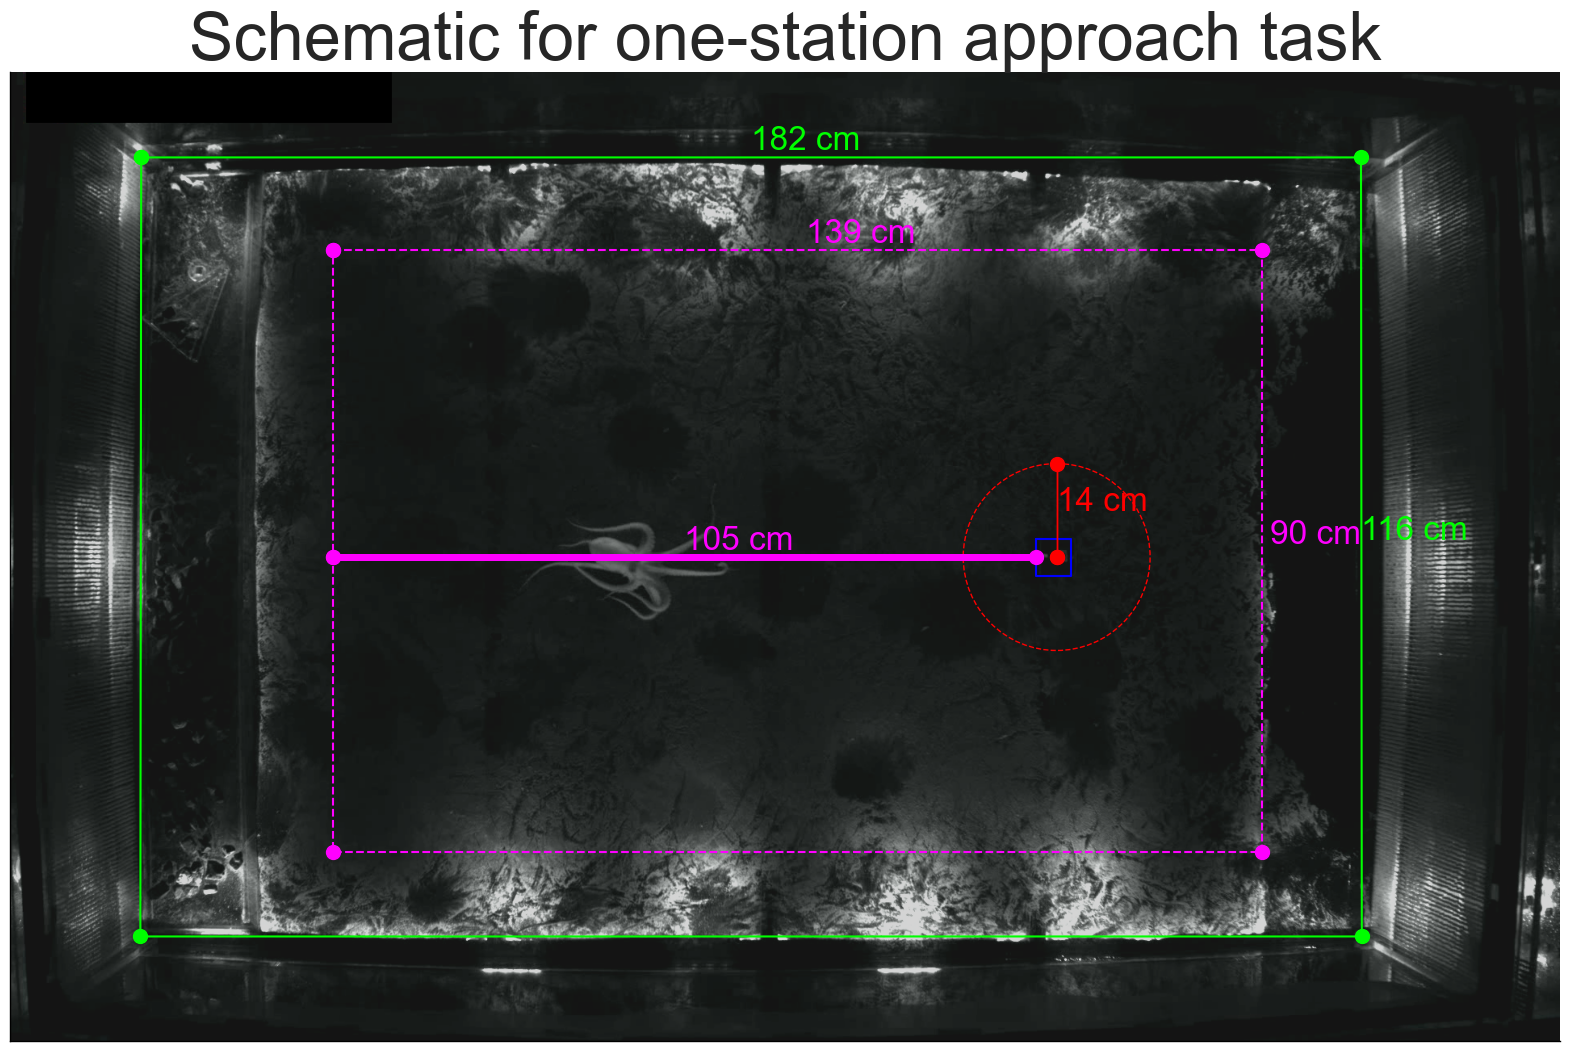

In [188]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

ax.imshow(adjust_image(frame1t, brightness=15 ,contrast=.8))

space_edges = [(162, 105), (1673, 105), (1674, 1070), (161, 1070)]
space_edges_x, space_edges_y = get_polygon_coords(space_edges)
for i in range(len(space_edges)-2):
    (xd, yd), D = get_draw_distance_info((space_edges[i], space_edges[i+1]))
    D = int(D*cm_per_pixel)
    ax.text(xd, yd-10, str(D) + ' cm', color='lime', fontsize=24)
ax.plot(space_edges_x, space_edges_y, color='lime', marker='.', markersize=20)

station_1 = [(1270, 578), (1314,578), (1314, 624), (1270, 624)]
st_1x, st_1y = get_polygon_coords(station_1)
ax.plot(st_1x,st_1y, color='blue')

xm = 1296
ym = 600
circle = patches.Circle((xm, ym), 14/cm_per_pixel,  # center at (200, 150), radius 80
                       linewidth=1,
                       linestyle='--',
                       edgecolor='red',     # or any color you want
                       facecolor='none')    # transparent center
# Add the circle to the plot
ax.add_patch(circle)

circ_coords = [(xm, ym), (xm, ym - 14/cm_per_pixel)]
walking_x, walking_y = get_polygon_coords(circ_coords)
(xd, yd), D = get_draw_distance_info((circ_coords[0], circ_coords[1]))
D = int(D*cm_per_pixel)
ax.text(xd, yd, str(D) + ' cm', color='red', fontsize=24)
ax.plot(walking_x, walking_y, color='red', linewidth=1, marker='.', markersize=20)

walking_distance = [(400, 600), (1270, 600)]
walking_x, walking_y = get_polygon_coords(walking_distance)
(xd, yd), D = get_draw_distance_info((walking_distance[0], walking_distance[1]))
D = int(D*cm_per_pixel)
ax.text(xd, yd-10, str(D) + ' cm', color='magenta', fontsize=24)
ax.plot(walking_x, walking_y, color='magenta', linewidth=5, marker='.', markersize=20)

tracking_box = [(400, 220), (1550, 220), (1550, 965), (400, 965)]
tracking_box_x, tracking_box_y = get_polygon_coords(tracking_box)
for i in range(len(space_edges)-2):
    (xd, yd), D = get_draw_distance_info((tracking_box[i], tracking_box[i+1]))
    D = int(D*cm_per_pixel)
    ax.text(xd+10, yd-10, str(D) + ' cm', color='magenta', fontsize=24)
ax.plot(tracking_box_x, tracking_box_y, color='magenta', linestyle='--', marker='.', markersize=20)


rect = patches.Rectangle((20, 0), 450, 60,
                        linewidth=2,
                        edgecolor='black',
                        facecolor='black')
# Add the rectangle to the plot
ax.add_patch(rect)


ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, color='black', width=2)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, color='black', width=2)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1)
    ax.spines[axis].set_color('black')

ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Schematic for one-station approach task', fontsize=48)

name_fig = ('1t_schematic')
fig.savefig(os.path.join(plot_dir, name_fig) , dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)